In [6]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, merge
from keras.engine import Input, Model
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
import json
import time

import matplotlib.pyplot as plt
from keras.utils import plot_model

x_train shape: (48000, 28, 28, 1)
48000 train samples
12000 test samples
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_35 (Conv2D)               (None, 28, 28, 4)     8           input_7[0][0]                    
____________________________________________________________________________________________________
conv2d_33 (Conv2D)               (None, 28, 28, 4)     8           input_7[0][0]                    
____________________________________________________________________________________________________
conv2d_36 (Conv2D)               (None, 28, 28, 6)     222         conv2d_35[0][0]                  
__________________

C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (1, 1), strides=(1, 1), activation="relu", kernel_initializer="he_normal", data_format="channels_last", padding="same")`
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (1, 1), strides=(1, 1), activation="relu", kernel_initializer="he_normal", data_format="channels_last", padding="same")`
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), strides=(1, 1), activation="relu", kernel_initializer="he_normal", data_format="channels_last", padding="same")`
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:61: UserWarning: Update your `Conv2D` call to the Keras 2 A


____________________________________________________________________________________________________
conv2d_37 (Conv2D)               (None, 28, 28, 8)     440         conv2d_36[0][0]                  
____________________________________________________________________________________________________
average_pooling2d_8 (AveragePool (None, 28, 28, 1)     0           input_7[0][0]                    
____________________________________________________________________________________________________
merge_7 (Merge)                  (None, 28, 28, 17)    0           conv2d_32[0][0]                  
                                                                   conv2d_34[0][0]                  
                                                                   conv2d_37[0][0]                  
                                                                   average_pooling2d_8[0][0]        
__________________________________________________________________________________________

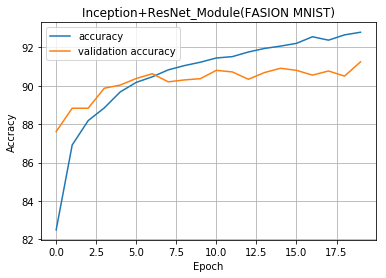

validation accuracy :  0.912499999841


In [18]:
nb_classes = 10

K.set_image_dim_ordering('th')

#load data from csv files
data_train = np.genfromtxt('fashion-mnist_train.csv', delimiter = ",", skip_header = 1)
data_test = np.genfromtxt('fashion-mnist_test.csv', delimiter = ",", skip_header = 1)

#data extraction
x_train = data_train[:,1:]
y_train = data_train[:,0]
x_test = data_test[:,1:] = data_test[:,1:]

#data transformation
y_train = to_categorical(y_train) #convert to categories
num_classes = y_train.shape[1] #10 labels
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#split validation and train dataset randomly
np.random.seed(12345)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, 
                                                  test_size=0.2, random_state=12345)

#reshape data into images
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# we reduce # filters by factor of 8 compared to original inception-v4
nb_filters_reduction_factor = 8

#%%time

#img_rows, img_cols = 32, 32
img_channels = 1

# in original inception-resnet-v2, these are 5, 10, 5, respectively
num_A_blocks = 1
num_B_blocks = 1
num_C_blocks = 1

inputs = Input(shape=(img_rows, img_cols, img_channels))

a = Convolution2D(32//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(inputs)
    
b = Convolution2D(32//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(inputs)
b = Convolution2D(32//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    
c = Convolution2D(32//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(inputs)
c = Convolution2D(48//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
c = Convolution2D(64//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)

d = AveragePooling2D((1, 1), strides=(1, 1), border_mode='valid', dim_ordering='tf')(inputs)
    
x = merge([a, b, c, d], mode='concat', concat_axis=-1)

x = Activation('relu')(x)

#x = AveragePooling2D(pool_size=(4, 4), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(nb_classes, activation='softmax')(x)

model = Model(input=inputs, output=predictions)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

plot_model(model, to_file='Inception_ResNet_model_MNIST.png', show_shapes=True, show_layer_names=True)

batch_size = 128
nb_epoch = 20

his= model.fit(x_train, y_train, 
                        batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                        validation_data=(x_test, y_test), shuffle=True,
                        callbacks=[])

# acc
acc = his.history["acc"]
val_acc = his.history["val_acc"]

acc_List = []
valacc_List = []

for i in acc:
    acc_List.append(i*100)

for i in val_acc:
    valacc_List.append(i*100)

plt.grid(True)
plt.plot(acc_List, label = 'accuracy')
plt.plot(valacc_List, label = 'validation accuracy')
plt.ylabel('Accracy')
plt.xlabel('Epoch')
plt.title(r'Inception+ResNet_Module(FASION MNIST)')
plt.legend()
plt.show()
print("validation accuracy : ", val_acc[-1])